In [268]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
#from scipy.ndimage import gaussian_filter1d
import sys

In [269]:
microwaveFrequency_list = np.array([3389.348, 3389.336, 3389.324, 3389.312, 3389.360])
objectiveLensPZT_list = np.array([7.20, 7.45, 7.70, 7.95, 6.95])
unique_param_list =[]
cxAtDifferentLayer_list = []
cxAtDifferentLayer_err_list = []
cyAtDifferentLayer_list = []
cyAtDifferentLayer_err_list = []

In [270]:
date = '20220512'
dataNo = 1
scanNo = 1

In [271]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [272]:
param_name = 'T0046: TOF in the vertical lattice (usec.)'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()
sample1 = unique_param[0]
sample2 = unique_param[3]
sample3 = unique_param[6]
unit = '[us]'

In [273]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print("No image")

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

img_trans_sample1 = []
img_trans_sample2 = []
img_trans_sample3 = []
for N in range(len(trans_files)):
    if scan_param[N] == sample1:
        img_trans_sample1 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample2:
        img_trans_sample2 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample3:
        img_trans_sample3 += [np.array(Image.open(trans_files[N]))]
img_trans_sample1 = np.average(img_trans_sample1,axis=0) -img_flat_ave
img_trans_sample2 = np.average(img_trans_sample2,axis=0) -img_flat_ave
img_trans_sample3 = np.average(img_trans_sample3,axis=0) -img_flat_ave

Text(0.5, 1.0, '12000.0[us]')

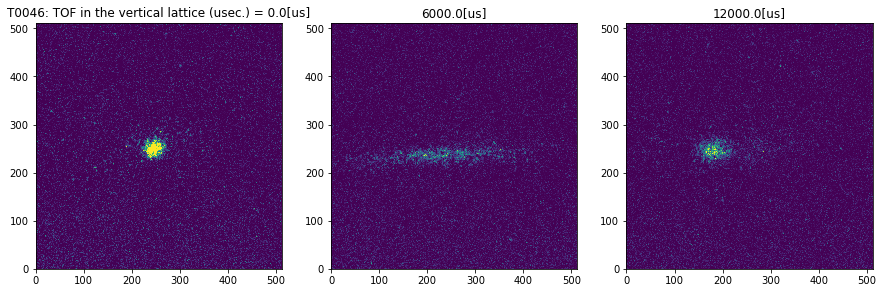

In [274]:
vmin = 0
vmax = 1000
xlim_1 = 120
xlim_2 = 320
ylim_1 = 140
ylim_2 = 340

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
# ax1.set_xlim(120,320)
# ax1.set_ylim(140,340)
ax1.set_title(param_name+ " = %.01f"%(sample1)+unit)

ax2 = fig.add_subplot(2,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
# ax2.set_xlim(120,320)
# ax2.set_ylim(140,340)
ax2.set_title("%.01f"%(sample2)+unit)

ax3 = fig.add_subplot(2,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, vmin=vmin, vmax=vmax, shading='auto')
ax3.set_aspect('equal')
# ax3.set_xlim(120,320)
# ax3.set_ylim(140,340)
ax3.set_title("%.01f"%(sample3)+unit)

fitParameter_0=5.061312529880181e-05(1.1342522082079434e-06)
fitParameter_1=252.23947359427973(0.28786786740158526)
fitParameter_2=22.298386716855095(0.586338244384231)
fitParameter_3=-0.0006968505210921881(4.8473041761250065e-05)


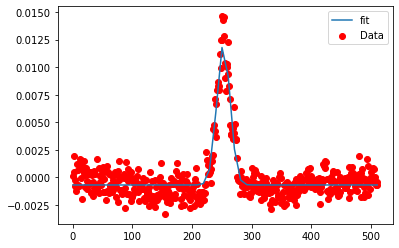

In [275]:
N=0
x_list =np.arange(np.shape(img_trans_list[0])[0])
nx=np.sum(img_trans_list[N], axis=1)/np.sum(img_trans_list[N])
ny=np.sum(img_trans_list[N], axis=1)/np.sum(img_trans_list[N])
CoMy = []
CoMx = []

for i in range(len(nx)):
    CoMx += [i*nx[i]]
for i in range(len(ny)):
    CoMy += [i*ny[i]]
CoMx = np.sum(CoMx)
CoMy = np.sum(CoMy)

para_ini=[np.max(nx), CoMx,200, np.mean(nx[0:5])]
# para_ini=[np.max(ny), 200 ,200, np.mean(ny[1:5])]

def gaussian_1d(x,*fit_param):
    return fit_param[0]*x*np.exp(-2*(x-fit_param[1])**2/fit_param[2]**2)+fit_param[3]

def linear(x, *fit_param):
    return fit_param[0]*x+fit_param[1]

def gaussian_1d_and_linear(x,*fit_param):
    return fit_param[0]*x*np.exp(-2*(x-fit_param[1])**2/fit_param[2]**2)+fit_param[3]+fit_param[4]*x

def fit_result(fit_func, x_data_list, y_data_list, initial_param_list, yerr=None):
    if (yerr is None):
        param, cov = scipy.optimize.curve_fit(fit_func, x_data_list, y_data_list, p0 = initial_param_list)
    else:
        param, cov = scipy.optimize.curve_fit(fit_func, x_data_list, y_data_list, p0 = initial_param_list, sigma=yerr)
    perr = np.sqrt(np.diag(cov))
    x_fit_list = np.linspace(np.min(x_data_list),np.max(x_data_list))
    y_fit_list = []
    for num in x_fit_list:
        y_fit_list.append(fit_func(num, *param))
    return param, perr, x_fit_list, y_fit_list

para_ini_linear =[-0.01, np.mean(nx)]
fit_to_subtract_gradient = fit_result(linear, x_list, nx, para_ini_linear)

def subtract_gradient(x_data_list, y_data_list, gradient, offset):
    output = []
    for i in range(len(x_data_list)):
        output.append(y_data_list[i]-(gradient*x_data_list[i]+offset))
    return output

nx_new = subtract_gradient(x_list, nx, fit_to_subtract_gradient[0][0], fit_to_subtract_gradient[0][1])

para_ini=[np.max(nx_new), 250,50, np.mean(nx_new[0:5])]
fitResultsOfSampleImage_list = fit_result(gaussian_1d, x_list, nx_new, para_ini)

for i in range(len(para_ini)):
    print("fitParameter_"+str(i)+"="+str(fitResultsOfSampleImage_list[0][i])+"("+str(fitResultsOfSampleImage_list[1][i])+")")

plt.scatter(x_list,nx_new, label='Data',c="r")
plt.plot(fitResultsOfSampleImage_list[2],fitResultsOfSampleImage_list[3],label="fit")
plt.legend()

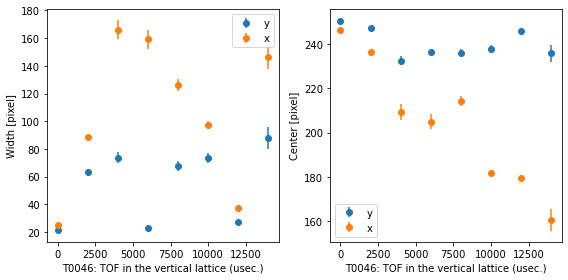

In [276]:
wx_list =[]
wy_list =[]
cx_list =[]
cy_list =[]
cx_err_list = []
cy_err_list = []
wx_err_list = []
wy_err_list = []
x_list =np.arange(np.shape(img_trans_list[0])[0])
y_list =np.arange(np.shape(img_trans_list[0])[1])

for i in range(len(unique_param)):
    nx_temp = []
    ny_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            nx_temp.append(np.sum(img_trans_list[j], axis=0)/np.sum(img_trans_list[j]))
            ny_temp.append(np.sum(img_trans_list[j], axis=1)/np.sum(img_trans_list[j]))
    nx_temp = np.mean(nx_temp, axis=0)
    ny_temp = np.mean(ny_temp, axis=0)
    CoMy = []
    CoMx = []
    for k in range(len(nx)):
        CoMx += [k*nx[k]]
    for k in range(len(ny)):
        CoMy += [k*ny[k]]
    CoMx = np.sum(CoMx)
    CoMy = np.sum(CoMy)
    para_ini=[np.max(nx_temp), CoMx, 150, np.mean(nx_temp[0:5])]
    fitResultsOfImageAlongX_list = fit_result(gaussian_1d, x_list, nx_temp, para_ini)
    para_ini= [np.max(ny_temp), CoMy,150, np.mean(ny_temp[0:5])]
    fitResultsOfImageAlongY_list = fit_result(gaussian_1d, y_list, ny_temp, para_ini)
    cx_list.append(fitResultsOfImageAlongX_list[0][1])
    cy_list.append(fitResultsOfImageAlongY_list[0][1])
    cx_err_list.append(fitResultsOfImageAlongX_list[1][1])
    cy_err_list.append(fitResultsOfImageAlongY_list[1][1])
    wx_list.append(fitResultsOfImageAlongX_list[0][2])
    wy_list.append(fitResultsOfImageAlongY_list[0][2])
    wx_err_list.append(fitResultsOfImageAlongX_list[1][2])
    wy_err_list.append(fitResultsOfImageAlongY_list[1][2])

xlabel = 'TOF in the vertical lattice [us]'

fig =plt.figure(figsize=[8,4])
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(param_name)
ax1.set_ylabel('Width [pixel]')
ax1.errorbar(unique_param,wy_list, wy_err_list,fmt='o',label ='y')
ax1.errorbar(unique_param,wx_list, wx_err_list,fmt='o',label='x')
ax1.legend()
# ax1.set_ylim(20, 100)

ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(unique_param,cy_list, cy_err_list, fmt='o',label ='y')
ax2.errorbar(unique_param,cx_list, cx_err_list,fmt='o',label='x')
ax2.set_xlabel(param_name)
ax2.set_ylabel('Center [pixel]')
# ax2.set_ylim(200, 260)
ax2.legend()

plt.tight_layout()
plt.show()

In [277]:
unique_param_list.append(unique_param)
cxAtDifferentLayer_list.append(cx_list)
cxAtDifferentLayer_err_list.append(cx_err_list)
cyAtDifferentLayer_list.append(cy_list)
cyAtDifferentLayer_err_list.append(cy_err_list)

In [278]:
date = '20220512'
dataNo = 2
scanNo = 2

In [279]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [280]:
param_name = 'T0046: TOF in the vertical lattice (usec.)'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()

In [281]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print("No image")

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

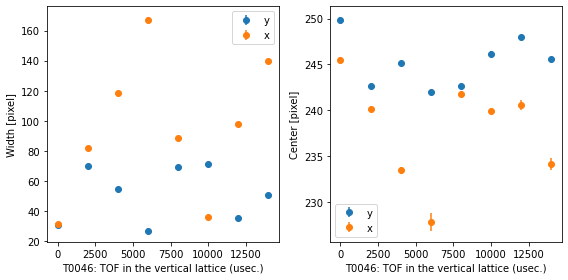

In [282]:
wx_list =[]
wy_list =[]
cx_list =[]
cy_list =[]
cx_err_list = []
cy_err_list = []
wx_err_list = []
wy_err_list = []
x_list =np.arange(np.shape(img_trans_list[0])[0])
y_list =np.arange(np.shape(img_trans_list[0])[1])

for i in range(len(unique_param)):
    nx_temp = []
    ny_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            nx_temp.append(np.sum(img_trans_list[j], axis=0)/np.sum(img_trans_list[j]))
            ny_temp.append(np.sum(img_trans_list[j], axis=1)/np.sum(img_trans_list[j]))
    nx_temp = np.mean(nx_temp, axis=0)
    ny_temp = np.mean(ny_temp, axis=0)
    CoMy = []
    CoMx = []
    for k in range(len(nx)):
        CoMx += [k*nx[k]]
    for k in range(len(ny)):
        CoMy += [k*ny[k]]
    CoMx = np.sum(CoMx)
    CoMy = np.sum(CoMy)
    para_ini=[np.max(nx_temp), CoMx, 150, np.mean(nx_temp[0:5])]
    fitResultsOfImageAlongX_list = fit_result(gaussian_1d, x_list, nx_temp, para_ini)
    para_ini= [np.max(ny_temp), CoMy,150, np.mean(ny_temp[0:5])]
    fitResultsOfImageAlongY_list = fit_result(gaussian_1d, y_list, ny_temp, para_ini)
    cx_list.append(fitResultsOfImageAlongX_list[0][1])
    cy_list.append(fitResultsOfImageAlongY_list[0][1])
    cx_err_list.append(fitResultsOfImageAlongX_list[1][1])
    cy_err_list.append(fitResultsOfImageAlongY_list[1][1])
    wx_list.append(fitResultsOfImageAlongX_list[0][2])
    wy_list.append(fitResultsOfImageAlongY_list[0][2])
    wx_err_list.append(fitResultsOfImageAlongX_list[1][2])
    wy_err_list.append(fitResultsOfImageAlongY_list[1][2])

xlabel = 'TOF in the vertical lattice [us]'

fig =plt.figure(figsize=[8,4])
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(param_name)
ax1.set_ylabel('Width [pixel]')
ax1.errorbar(unique_param,wy_list, wy_err_list,fmt='o',label ='y')
ax1.errorbar(unique_param,wx_list, wx_err_list,fmt='o',label='x')
ax1.legend()
# ax1.set_ylim(20, 100)

ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(unique_param,cy_list, cy_err_list, fmt='o',label ='y')
ax2.errorbar(unique_param,cx_list, cx_err_list,fmt='o',label='x')
ax2.set_xlabel(param_name)
ax2.set_ylabel('Center [pixel]')
# ax2.set_ylim(200, 260)
ax2.legend()

plt.tight_layout()
plt.show()

In [283]:
unique_param_list.append(unique_param)
cxAtDifferentLayer_list.append(cx_list)
cxAtDifferentLayer_err_list.append(cx_err_list)
cyAtDifferentLayer_list.append(cy_list)
cyAtDifferentLayer_err_list.append(cy_err_list)

In [284]:
date = '20220512'
dataNo = 3
scanNo = 3

In [285]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [286]:
param_name = 'T0046: TOF in the vertical lattice (usec.)'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()

In [287]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print("No image")

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

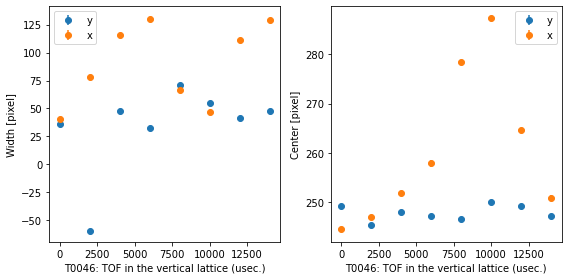

In [288]:
wx_list =[]
wy_list =[]
cx_list =[]
cy_list =[]
cx_err_list = []
cy_err_list = []
wx_err_list = []
wy_err_list = []
x_list =np.arange(np.shape(img_trans_list[0])[0])
y_list =np.arange(np.shape(img_trans_list[0])[1])

for i in range(len(unique_param)):
    nx_temp = []
    ny_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            nx_temp.append(np.sum(img_trans_list[j], axis=0)/np.sum(img_trans_list[j]))
            ny_temp.append(np.sum(img_trans_list[j], axis=1)/np.sum(img_trans_list[j]))
    nx_temp = np.mean(nx_temp, axis=0)
    ny_temp = np.mean(ny_temp, axis=0)
    CoMy = []
    CoMx = []
    for k in range(len(nx_temp)):
        CoMx += [k*nx_temp[k]]
    for k in range(len(ny_temp)):
        CoMy += [k*ny_temp[k]]
    CoMx = np.sum(CoMx)
    CoMy = np.sum(CoMy)
    para_ini=[np.max(nx_temp), CoMx, 200, np.mean(nx_temp[0:5])]
    fitResultsOfImageAlongX_list = fit_result(gaussian_1d, x_list, nx_temp, para_ini)
    para_ini= [np.max(ny_temp), CoMy,200, np.mean(ny_temp[0:5])]
    fitResultsOfImageAlongY_list = fit_result(gaussian_1d, y_list[100:400], ny_temp[100:400], para_ini)
    cx_list.append(fitResultsOfImageAlongX_list[0][1])
    cy_list.append(fitResultsOfImageAlongY_list[0][1])
    cx_err_list.append(fitResultsOfImageAlongX_list[1][1])
    cy_err_list.append(fitResultsOfImageAlongY_list[1][1])
    wx_list.append(fitResultsOfImageAlongX_list[0][2])
    wy_list.append(fitResultsOfImageAlongY_list[0][2])
    wx_err_list.append(fitResultsOfImageAlongX_list[1][2])
    wy_err_list.append(fitResultsOfImageAlongY_list[1][2])

xlabel = 'TOF in the vertical lattice [us]'

fig =plt.figure(figsize=[8,4])
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(param_name)
ax1.set_ylabel('Width [pixel]')
ax1.errorbar(unique_param,wy_list, wy_err_list,fmt='o',label ='y')
ax1.errorbar(unique_param,wx_list, wx_err_list,fmt='o',label='x')
ax1.legend()
# ax1.set_ylim(20, 100)

ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(unique_param,cy_list, cy_err_list, fmt='o',label ='y')
ax2.errorbar(unique_param,cx_list, cx_err_list,fmt='o',label='x')
ax2.set_xlabel(param_name)
ax2.set_ylabel('Center [pixel]')
# ax2.set_ylim(200, 260)
ax2.legend()

plt.tight_layout()
plt.show()

In [289]:
unique_param_list.append(unique_param)
cxAtDifferentLayer_list.append(cx_list)
cxAtDifferentLayer_err_list.append(cx_err_list)
cyAtDifferentLayer_list.append(cy_list)
cyAtDifferentLayer_err_list.append(cy_err_list)

In [290]:
date = '20220512'
dataNo = 4
scanNo = 4

In [291]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [292]:
param_name = 'T0046: TOF in the vertical lattice (usec.)'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()

In [293]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print("No image")

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

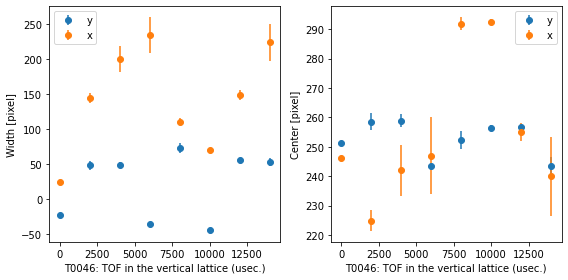

In [294]:
wx_list =[]
wy_list =[]
cx_list =[]
cy_list =[]
cx_err_list = []
cy_err_list = []
wx_err_list = []
wy_err_list = []
x_list =np.arange(np.shape(img_trans_list[0])[0])
y_list =np.arange(np.shape(img_trans_list[0])[1])

for i in range(len(unique_param)):
    nx_temp = []
    ny_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            nx_temp.append(np.sum(img_trans_list[j], axis=0)/np.sum(img_trans_list[j]))
            ny_temp.append(np.sum(img_trans_list[j], axis=1)/np.sum(img_trans_list[j]))
    nx_temp = np.mean(nx_temp, axis=0)
    ny_temp = np.mean(ny_temp, axis=0)
    para_ini_linear =[(ny_temp[-1]-ny_temp[0])/(y_list[-1]-y_list[0]), np.mean(ny_temp)]
    ny_temp = subtract_gradient(y_list, ny_temp, fit_to_subtract_gradient[0][0], fit_to_subtract_gradient[0][1])
    CoMy = []
    CoMx = []
    for k in range(len(nx_temp)):
        CoMx += [k*nx_temp[k]]
    for k in range(len(ny_temp)):
        CoMy += [k*ny_temp[k]]
    CoMx = np.sum(CoMx)
    CoMy = np.sum(CoMy)
    para_ini=[np.max(nx_temp), CoMx, 100, np.mean(nx_temp[0:5])]
    fitResultsOfImageAlongX_list = fit_result(gaussian_1d, x_list, nx_temp, para_ini)
    para_ini= [np.max(ny_temp), 250,100, np.mean(ny_temp[0:5])]
    fitResultsOfImageAlongY_list = fit_result(gaussian_1d, y_list[100:400], ny_temp[100:400], para_ini)
    cx_list.append(fitResultsOfImageAlongX_list[0][1])
    cy_list.append(fitResultsOfImageAlongY_list[0][1])
    cx_err_list.append(fitResultsOfImageAlongX_list[1][1])
    cy_err_list.append(fitResultsOfImageAlongY_list[1][1])
    wx_list.append(fitResultsOfImageAlongX_list[0][2])
    wy_list.append(fitResultsOfImageAlongY_list[0][2])
    wx_err_list.append(fitResultsOfImageAlongX_list[1][2])
    wy_err_list.append(fitResultsOfImageAlongY_list[1][2])

xlabel = 'TOF in the vertical lattice [us]'

fig =plt.figure(figsize=[8,4])
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(param_name)
ax1.set_ylabel('Width [pixel]')
ax1.errorbar(unique_param,wy_list, wy_err_list,fmt='o',label ='y')
ax1.errorbar(unique_param,wx_list, wx_err_list,fmt='o',label='x')
ax1.legend()
# ax1.set_ylim(20, 100)

ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(unique_param,cy_list, cy_err_list, fmt='o',label ='y')
ax2.errorbar(unique_param,cx_list, cx_err_list,fmt='o',label='x')
ax2.set_xlabel(param_name)
ax2.set_ylabel('Center [pixel]')
# ax2.set_ylim(200, 260)
ax2.legend()

plt.tight_layout()
plt.show()

In [295]:
unique_param_list.append(unique_param)
cxAtDifferentLayer_list.append(cx_list)
cxAtDifferentLayer_err_list.append(cx_err_list)
cyAtDifferentLayer_list.append(cy_list)
cyAtDifferentLayer_err_list.append(cy_err_list)

In [296]:
date = '20220512'
dataNo = 5
scanNo = 5

In [297]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [298]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print("No image")

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

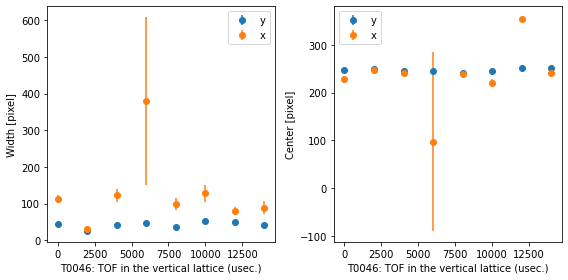

In [299]:
wx_list =[]
wy_list =[]
cx_list =[]
cy_list =[]
cx_err_list = []
cy_err_list = []
wx_err_list = []
wy_err_list = []
x_list =np.arange(np.shape(img_trans_list[0])[0])
y_list =np.arange(np.shape(img_trans_list[0])[1])

for i in range(len(unique_param)):
    nx_temp = []
    ny_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            nx_temp.append(np.sum(img_trans_list[j], axis=0)/np.sum(img_trans_list[j]))
            ny_temp.append(np.sum(img_trans_list[j], axis=1)/np.sum(img_trans_list[j]))
    nx_temp = np.mean(nx_temp, axis=0)
    ny_temp = np.mean(ny_temp, axis=0)
    para_ini_linear =[(ny_temp[-1]-ny_temp[0])/(y_list[-1]-y_list[0]), np.mean(ny_temp)]
    ny_temp = subtract_gradient(y_list, ny_temp, fit_to_subtract_gradient[0][0], fit_to_subtract_gradient[0][1])
    CoMy = []
    CoMx = []
    for k in range(len(nx_temp)):
        CoMx += [k*nx_temp[k]]
    for k in range(len(ny_temp)):
        CoMy += [k*ny_temp[k]]
    CoMx = np.sum(CoMx)
    CoMy = np.sum(CoMy)
    para_ini=[np.max(nx_temp), CoMx, 300, np.mean(nx_temp[0:5])]
    fitResultsOfImageAlongX_list = fit_result(gaussian_1d, x_list[100:400], nx_temp[100:400], para_ini)
    para_ini= [np.max(ny_temp), CoMy,300, np.mean(ny_temp[0:5])]
    fitResultsOfImageAlongY_list = fit_result(gaussian_1d, y_list[100:400], ny_temp[100:400], para_ini)
    cx_list.append(fitResultsOfImageAlongX_list[0][1])
    cy_list.append(fitResultsOfImageAlongY_list[0][1])
    cx_err_list.append(fitResultsOfImageAlongX_list[1][1])
    cy_err_list.append(fitResultsOfImageAlongY_list[1][1])
    wx_list.append(fitResultsOfImageAlongX_list[0][2])
    wy_list.append(fitResultsOfImageAlongY_list[0][2])
    wx_err_list.append(fitResultsOfImageAlongX_list[1][2])
    wy_err_list.append(fitResultsOfImageAlongY_list[1][2])

xlabel = 'TOF in the vertical lattice [us]'

fig =plt.figure(figsize=[8,4])
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(param_name)
ax1.set_ylabel('Width [pixel]')
ax1.errorbar(unique_param,wy_list, wy_err_list,fmt='o',label ='y')
ax1.errorbar(unique_param,wx_list, wx_err_list,fmt='o',label='x')
ax1.legend()
# ax1.set_ylim(20, 100)

ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(unique_param,cy_list, cy_err_list, fmt='o',label ='y')
ax2.errorbar(unique_param,cx_list, cx_err_list,fmt='o',label='x')
ax2.set_xlabel(param_name)
ax2.set_ylabel('Center [pixel]')
# ax2.set_ylim(200, 260)
ax2.legend()

plt.tight_layout()
plt.show()

244.72248286034304

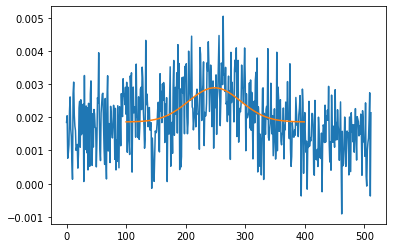

In [300]:
plt.plot(x_list, nx_temp)
plt.plot(fitResultsOfImageAlongX_list[2], fitResultsOfImageAlongX_list[3])

CoMx

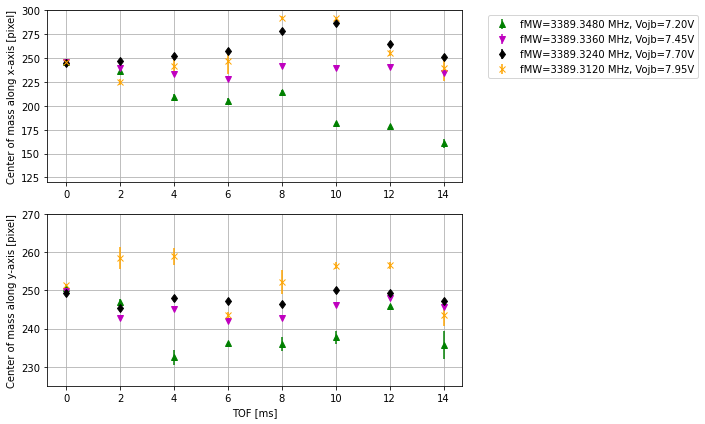

In [325]:
color_list = ["green", "m", "black","orange"]
shape_list = ["^","v","d","x"]
fig =plt.figure(figsize=[10,6])
ax1 = fig.add_subplot(2,1,1)
ax1.set_ylabel('Center of mass along x-axis [pixel]')
for i in range(len(unique_param_list)):
    ax1.errorbar(unique_param_list[i]/1000,cxAtDifferentLayer_list[i], cxAtDifferentLayer_err_list[i],fmt=shape_list[i],c=color_list[i],label ='fMW=%.04f MHz, Vojb=%.02fV'%(microwaveFrequency_list[i],objectiveLensPZT_list[i]))
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
ax1.grid()
ax1.set_ylim(120, 300)

ax2 = fig.add_subplot(2,1,2)
ax2.set_xlabel("TOF [ms]")
ax2.set_ylabel('Center of mass along y-axis [pixel]')
for i in range(len(unique_param_list)):
    ax2.errorbar(unique_param_list[i]/1000,cyAtDifferentLayer_list[i], cyAtDifferentLayer_err_list[i],fmt=shape_list[i],c=color_list[i],label ='fMW=%.04f MHz, Vojb=%.02fV'%(microwaveFrequency_list[i],objectiveLensPZT_list[i]))
# ax2.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
ax2.grid()
ax2.set_ylim(225, 270)

plt.tight_layout()
plt.show()